In [1]:
#######################
### LOAD IN MODULES ###
#######################

import trimesh
import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns
from shapely.geometry import Polygon, Point, LinearRing
from shapely.ops import nearest_points
from scipy.spatial import Delaunay
from shapely.validation import make_valid

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

from shapely.geometry import Polygon, Point

def grid_points_in_polygon(polygon_coords, spacing):
    """
    Generates a grid of points within a polygon.

    Args:
        polygon_coords: A list of (x, y) tuples defining the polygon's vertices.
        spacing: The desired spacing between grid points.

    Returns:
        A list of (x, y) tuples representing the grid points within the polygon.
    """
    polygon = Polygon(polygon_coords)
    min_x, min_y, max_x, max_y = polygon.bounds

    x_coords = np.arange(min_x, max_x + spacing, spacing)
    y_coords = np.arange(min_y, max_y + spacing, spacing)
    xv, yv = np.meshgrid(x_coords, y_coords)

    grid_points_x = []
    grid_points_y = []
    for x, y in zip(xv.flatten(), yv.flatten()):
        point = Point(x, y)
        if polygon.contains(point):
            grid_points_x.append(x)
            grid_points_y.append(y)

    grid_points = np.column_stack((grid_points_x, grid_points_y))

    return grid_points

def shortest_distance_to_polygon(point_coords, polygon_coords):
    """
    Calculates the shortest distance from a point to a polygon outline.

    Args:
        point_coords (tuple): Coordinates of the point (x, y).
        polygon_coords (list): List of coordinate tuples defining the polygon's vertices.

    Returns:
        float: The shortest distance from the point to the polygon outline.
    """
    point = Point(point_coords)
    polygon = Polygon(polygon_coords)

    # Get the boundary (outline) of the polygon as a LinearRing
    polygon_boundary = polygon.boundary

    # Find the nearest point on the polygon boundary to the given point
    nearest_point = nearest_points(point, polygon_boundary)[1]

    # Calculate the distance between the point and the nearest point on the boundary
    distance = point.distance(nearest_point)

    return distance

def delaunay_triangulation_within_polygon(points, polygon):
    """
    Generates a Delaunay triangulation of a set of points that lie within a given polygon.

    Args:
        points: A list of (x, y) coordinate tuples or a NumPy array of shape (n, 2) representing the points.
        polygon: A {Link: Shapely Polygon https://shapely.readthedocs.io/en/stable/manual.html#polygon} object representing the polygon.

    Returns:
        A tuple containing:
        - A NumPy array of shape (n, 2) representing the coordinates of the vertices of the triangulation.
        - A NumPy array of shape (m, 3) representing the indices of the vertices that form each triangle.
    """

    # Create Delaunay triangulation
    delaunay = Delaunay(points)

    # Filter triangles that fall outside the polygon
    triangles_within_polygon = []
    for triangle_indices in delaunay.simplices:
        triangle_points = points[triangle_indices]
        triangle_polygon = Polygon(triangle_points)

        if triangle_polygon.within(polygon):
            triangles_within_polygon.append(triangle_indices)

    # Return the filtered triangles
    return points, np.array(triangles_within_polygon)

In [3]:
#############################################
### MAKE A LIST OF IMAGE NAMES TO READ IN ###
#############################################

# list of file names to analyze
images = ["Col-0_3UF.JPG",
          "Ull2-3_39UF.JPG"
         ]

# number of plants
num_plants = len(images)

# list of pixels per centimeter for each image
px_cm_list = [468,
              466.017
             ]

# list of genotypes based on file names
genotypes = []
for i in images:
    genotypes.append(i[0:images[0].index("_")])


# Image processing, landmarking, scaling

In [4]:
######################
### SET PARAMETERS ###
######################

######################
######################
res = 20 # resolution to interpolate points on each side of leaf
######################
######################

gauss = 51 # size of Gaussian blur kernel window, must be positive and odd
ker = 5 # size of dilation/erosion kernel window
iterations = 1 # number of dilations/erosions
target_ang = 90 # angle to rotate leaf to
num_leaves = 5 # number of leaves per image
inter_tip_ind = res+1 # the index of the tip in the interpolated leaf

# arrays to store leaves are as follows:
# number of plants x
# number of leaves x
# x and y coordinates
# number of points

leaves_cm_arr = np.zeros((num_plants, num_leaves, 2, res*2)) # array of leaves in cm
leaves_scale_arr = np.zeros((num_plants, num_leaves, 2, res*2)) # array of scaled leaves

for i in range(num_plants):

    curr_image = images[i] # select current image
    px_cm = px_cm_list[i] # select current px per cm value
    leaf_ind = i # store the index for saving data at end
    
    print(curr_image)

    ########################
    ### IMAGE PROCESSING ###
    ########################

    img = cv2.flip(cv2.cvtColor(cv2.imread(curr_image),cv2.COLOR_BGR2GRAY),0) # convert to grayscale, flip vertically
    blur = cv2.GaussianBlur(img,(gauss,gauss),0) # apply Gaussian blue
    ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # threshold to binary
    invbin = cv2.bitwise_not(thresh) # invert the binary
    kernel = np.ones((ker,ker),np.uint8)  # define kernel for dilation/erosion
    dilation_img = cv2.dilate(invbin,kernel,iterations = iterations) # dilate
    erode_img = cv2.erode(dilation_img,kernel,iterations = iterations) # erode

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(erode_img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    ############################
    ### FIND LARGEST OBJECTS ###
    ############################

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:num_leaves] # top areas x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:num_leaves] # top areas y vals

    ###########################
    ### ORDER LEFT TO RIGHT ###
    ###########################  

    x_means = [] # store mean x values of largest leaves
    for lf in sorted_x_conts: # for the largest objects/leaves
        x_means.append(np.mean(lf)) # append mean x val of current leaf

    order_inds =np.argsort(x_means) # get indices to order leaves left to right
    ordered_x_leaves = np.array(sorted_x_conts, dtype=object)[order_inds] # leaf x vals, left to right
    ordered_y_leaves = np.array(sorted_y_conts, dtype=object)[order_inds] # leaf y vals, left to right

    ##########################
    ### INTERPOLATE LEAVES ###
    ##########################

    inter_arr = np.zeros((num_leaves,2,res*2)) # 3D array, 5 leaves by x and y vals by number of points

    for lf in range(5): # for each of the 5 leaves

        curr_lf_x = ordered_x_leaves[lf] # select current leaf x vals
        curr_lf_y = ordered_y_leaves[lf] # select current leaf y vals

        dist_ori = [] # store distance to origin (leaf base) for each point
        for pt in range(len(curr_lf_x)):
            dist_ori.append(euclid_dist(curr_lf_x[0],curr_lf_y[0],curr_lf_x[pt],curr_lf_y[pt]))

        tip_ind = dist_ori.index(max(dist_ori)) # set tip index as farthest from the base

        left_inter_x, left_inter_y = interpolation(curr_lf_x[:tip_ind],curr_lf_y[:tip_ind], res) # interpolate left side, base to tip
        right_inter_x, right_inter_y = interpolation(curr_lf_x[tip_ind:-1],curr_lf_y[tip_ind:-1], res) # interpolate right side, tip to base

        inter_xvals = np.concatenate((left_inter_x, right_inter_x)) # concatenate x vals
        inter_yvals = np.concatenate((left_inter_y, right_inter_y)) # concatenate y vals

        inter_arr[lf,:,:] = np.row_stack((inter_xvals, inter_yvals))/px_cm # create a 2 x res array, x/y vals first followed by points for each leaf in cm

    ###############################
    ### ROTATE AND SCALE LEAVES ###
    ###############################

    cm_arr = np.zeros((num_leaves,2,res*2)) # 5 leaves by x/y vals by number of points for cm leaves
    scale_arr = np.zeros((num_leaves,2,res*2)) # 5 leaves by x/y vals by number of points for scaled leaves

    for lf in range(5): # for each of the 5 leaves

        base_curr_lf = inter_arr[lf,:,0] # get base point of current leaf
        tip_curr_lf = inter_arr[lf,:,inter_tip_ind] # get tip point of current leaf

        ang = angle_between(tip_curr_lf, base_curr_lf, (base_curr_lf[0]+1,base_curr_lf[1]) ) # get leaf angle
        rot_x, rot_y = rotate_points(inter_arr[lf,0,:], inter_arr[lf,1,:], ang) # rotate leaf upwards
        trans_x, trans_y = rot_x - rot_x[0], -(rot_y - rot_y[0]) # translate leaf base to origin, in cm
        scale_x, scale_y = trans_x/trans_y[inter_tip_ind], trans_y/trans_y[inter_tip_ind] # scale length to 1

        cm_arr[lf,:,:] = np.row_stack((trans_x, trans_y)) # create a 2 x res array in cm, x/y vals first followed by points for each leaf
        scale_arr[lf,:,:] = np.row_stack((scale_x, scale_y)) # create a 2 x res array in cm, x/y vals first followed by points for each leaf
        
    ##################
    ### STORE DATA ###
    ##################
    
    leaves_cm_arr[leaf_ind,:,:,:] = cm_arr
    leaves_scale_arr[leaf_ind,:,:,:] = scale_arr


Col-0_3UF.JPG
Ull2-3_39UF.JPG


# Create synthetic mesh rosette model

In [5]:
angle_max = 40/4 # maximum angle interval, divide by maximum leaf index
geno = 0 # select genotype

In [6]:
golden_ang = 137.507764 # in degrees
grid_density = 0.05 # density of the grid
leaf_height = 0.8 # scaling of leaf height (the interior of the leaf)

In [7]:
pts_3D = [] # a list of 3D point arrays for each leaf
tris_3D = [] # a list of indices for triangles of each leaf
meshes = [] # a list of trimesh objects for each leaf

for i in range(5): # for each leaf in the series
    
    leaf = i # select leaf
    
    curr_lf_x = leaves_cm_arr[geno,leaf,0,:] # get leaf x vals
    curr_lf_y = leaves_cm_arr[geno,leaf,1,:] # get leaf y vals
    
    curr_lf = np.column_stack((curr_lf_x, curr_lf_y)) # combine leaf vals into array
    grid_pts = grid_points_in_polygon(curr_lf, grid_density) # calculate grid points

    #####################################
    # Delauney triangulation
    # tris = indices of individual triangles in points
    pts, tris = delaunay_triangulation_within_polygon(grid_pts, Polygon(curr_lf)) # calculate Delauney triangulation
    #####################################
    
    # rotate leaf
    rot_x, rot_y = rotate_points(curr_lf[:,0], curr_lf[:,1], golden_ang*leaf)
    rot_lf = np.column_stack((rot_x, rot_y))
    
    # rotate grid
    rot_x, rot_y = rotate_points(grid_pts[:,0], grid_pts[:,1], golden_ang*leaf)
    rot_grid = np.column_stack((rot_x, rot_y))
    
    # get distances of each grid point to polygon boundary
    dists=[]
    for i in range(len(rot_grid)):
        dists.append(shortest_distance_to_polygon((rot_grid[i,0],rot_grid[i,1]),rot_lf))
    
    # scale distances
    dist_arr = np.array(dists)*leaf_height
    
    # get elevation for each grid point
    elev=[]
    for i in range(len(rot_grid)):
        adj = euclid_dist(0,0,rot_grid[i,0],rot_grid[i,1]) # distance from origin, or adjacent val
        opp = adj*np.tan(np.radians(angle_max*leaf)) # opposite, or elevation value
        elev.append(opp) # save elevation
    
    rot_3d = np.column_stack((rot_grid, dist_arr)) # create 3D array, not elevated
    
    rot_3d[:,2] = rot_3d[:,2]+elev # add elevation values to height

    #####################################
    pts_3D.append(rot_3d)
    tris_3D.append(tris)

Visualize using matplotlib 3D

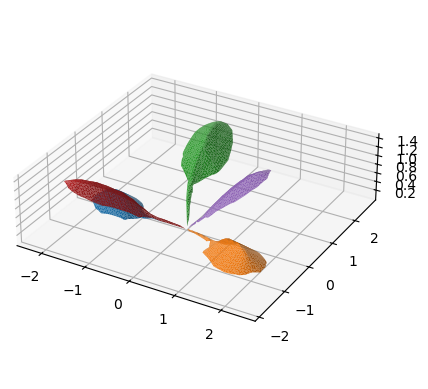

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(pts_3D)):
    ax.plot_trisurf(pts_3D[i][:, 0], pts_3D[i][:, 1], pts_3D[i][:, 2], triangles=tris_3D[i])
    plt.gca().set_aspect("equal")


# Concatenate the leaf mesh objects

In [165]:
mesh = trimesh.Trimesh(vertices=pts_3D[0], faces=tris_3D[0])

for i in range(1, len(pts_3D)):
    new_mesh = trimesh.Trimesh(vertices=pts_3D[i], faces=tris_3D[i])
    mesh = trimesh.util.concatenate(mesh, new_mesh)

mesh.show()


Get vertices and faces of combined mesh object

In [166]:
# Get the vertices (coordinates of each vertex)
vertices = mesh.vertices

# Get the faces (indices of vertices that form each triangle)
faces = mesh.faces

Plot the combined mesh object in 3D

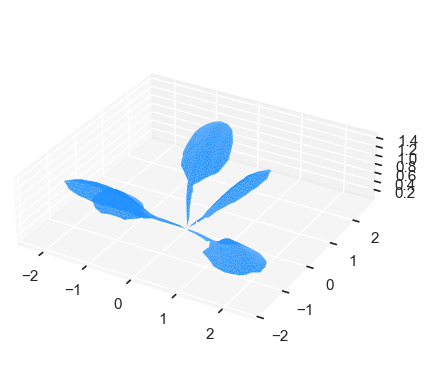

In [187]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], triangles=faces, edgecolor=None, facecolor="dodgerblue", linewidth=0, shade=True)

plt.gca().set_aspect("equal")

# Sampling rays

In [178]:
import math

def fibonacci_sphere(samples=1000):

    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points

In [179]:
n = 10000 # set number of sphere points
radius = 5

fibo_pts = fibonacci_sphere(samples = n) # calculate points

fibo_arr = np.array(fibo_pts) # turn tuples into array

ray_origins = fibo_arr[fibo_arr[:,2]>0]*radius # select points in the positive hemisphere


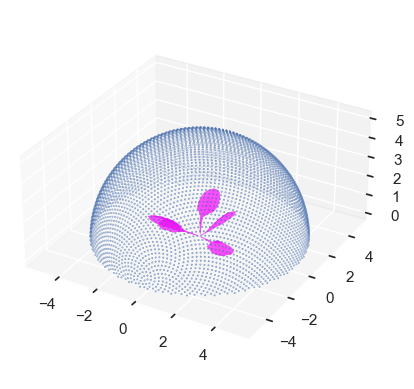

In [188]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(ray_origins[:,0], ray_origins[:,1], ray_origins[:,2], s=0.1)

ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], triangles=faces, edgecolor=None, facecolor="magenta", linewidth=0)
    
plt.gca().set_aspect("equal")

# Ray casting

In [189]:
oris = [] # store the hemisphere ray origins
dirs = [] # store the pts on the leaf, ray directions
for i in range(len(ray_origins)):
    for j in range(len(vertices)):
        oris.append(ray_origins[i])
        dirs.append(vertices[j])

oris = np.array(oris)
dirs = np.array(dirs)

In [190]:
locations, index_ray, index_tri = mesh.ray.intersects_location(ray_origins=oris,ray_directions=dirs)

In [197]:
print("For", len(ray_origins), "ray origins")
print("There are", len(oris), "rays and", len(locations), "interceptions")

For 4999 ray origins
There are 11557688 rays and 41938 interceptions


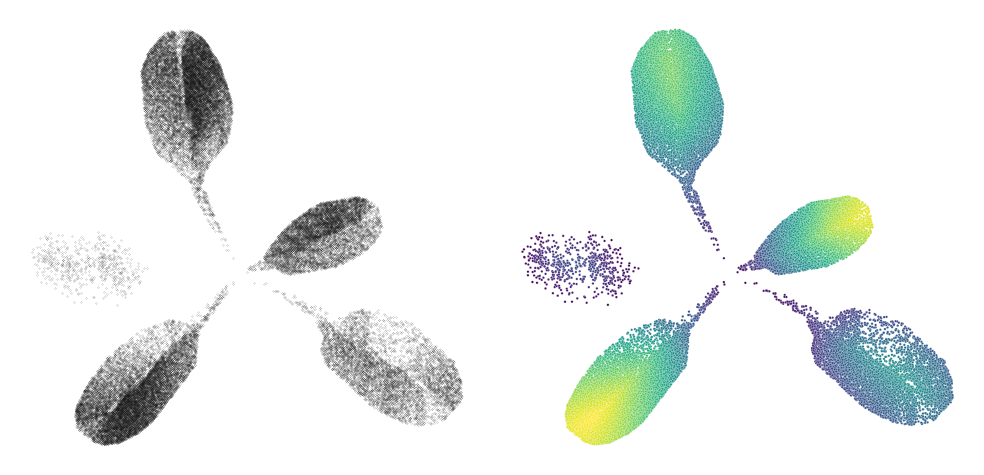

In [203]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.scatter(locations[:,0], locations[:,1], s=0.01, alpha=1, c="k")
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(122)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.scatterplot(x=locations[:,0], y=locations[:,1], hue=locations[:,2], palette="viridis", s=3, legend=False, facecolor="gray")
plt.gca().set_aspect("equal")
plt.axis("off")

plt.tight_layout()

# Export STL file

In [45]:
mesh1 = mesh.copy()
mesh1.apply_scale(1.1)
mesh1.export('rosette.stl')

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xca\x10\x00\x00Xn\t\xbf$u\xac\xbe\x04\x06F?\'\xf2\x19\xc0\x9a\xe2\x15\xbdv\x05\xa0<\'\xf2\x19\xc0(\xca\x96<\xb5\x1b2=Ew\x1d\xc0(\xca\x96<!\x16\xae;\x00\x00\x18\xb6\x87>\x87\xd1\x16?.iC?\xb4J\xca\xbf\xa3n\x03?f\x91\n=v@\xc3\xbf\xa3n\x03?\x87\\q<\xf1T\xd1\xbf\x1e\x83\x11?4\xb2+<\x00\x00\xf2\x8b\x90\xbeZ\x9b\x16?#\xfcA?\xe9\xe7\x12\xc0\xa3n\x03?\x13\xc9\x01<\xcab\x0f\xc0\xa3n\x03?=\xc2\xe8<\xac\xdd\x0b\xc0\x1e\x83\x11?\x9eD\xcb;\x00\x003h\xed\xbe/\x1b\xde\xbe\xef\xc4E?\xe9\xe7\x12\xc0~\x1c\x16\xbe\x9d\x93\xd1<\xe9\xe7\x12\xc0$\x95\xbb\xbd\x1aJg=\x08m\x16\xc0$\x95\xbb\xbd\xb9%\xc0<\x00\x00\xe3\xe5\x00?mQ\xbd\xbe\x05\xe7G?\x80\x17\xa7\xbf*`\x83\xbe5\x8aL=\x80\x17\xa7\xbf \x

# Read in STL files into trimesh

In [47]:
mesh = trimesh.load_mesh('rosette.stl')
mesh.show()